In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
 olist_customers=pd.read_csv('olist_customers_dataset.csv')

In [3]:
olist_orders=pd.read_csv('olist_orders_dataset.csv')

In [4]:
olist_order_items=pd.read_csv('olist_order_items_dataset.csv')

За покупки примем оплаченные заказы. 
За факт оплаты можем считать заполненную колонку order_approved_at —  время подтверждения оплаты заказа

Посмотрим на статусы заказов:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

Заказы со статусом created не являются оплаченными - в колонке order_approved_at стоят пропуски

In [5]:
olist_orders.query('order_status == "created"').order_approved_at.isna().sum()

5

А вот заказы со статусоми approved и дальше уже являются оплаченными:

In [6]:
olist_orders.query('order_status == "approved"').order_approved_at.isna().sum()

0

In [7]:
olist_orders.query('order_status == "invoiced"').order_approved_at.isna().sum()

0

Значит нам подойдут заказы со статусом approved, invoiced, processing, shipped, delivered.

Заказы со статусом canceled (отменен) по определению не подходят.
Заказы со статусом unavailable так же не подходят, т.к. скорее всего так же будут в дальнейшем отменены.

In [8]:
olist_orders.query('order_status in ["approved","invoiced","processing","shipped","delivered"]').order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'approved'],
      dtype=object)

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Для подсчета уникальных пользоваталей, совершивших 1 покупку нам понадобится датасет olist_orders_dataset и  olist_customers_dataset. В первом содержатся идентификаторы всех заказов, а во втором уникальные идентификаторы пользователей. Выполним слияние по общей колонке customer_id

In [9]:
olist_orders_customers = olist_orders.merge(olist_customers, on='customer_id') 

Выберим только оплаченные заказы и сгруппируем по уникальным идентификаторам пользователей,
затем для каждого уникального пользователя посчитаем количество покупок.

In [10]:
orders_count=olist_orders_customers.query('order_status in ["approved","invoiced","processing","shipped","delivered"]').\
groupby('customer_unique_id',as_index=False).agg({'order_id':'count'}).rename(columns={'order_id':'orders_count'}) 


С помощью функции value_counts выберем количество пользователей с одной совершенной покупкой.

In [11]:
orders_count

,customer_unique_id,orders_count
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94981,fffcf5a5ff07b0908bd4e2dbc735a684,1
94982,fffea47cd6d3cc0a88bd621562a9d061,1
94983,ffff371b4d645b6ecea244b27531430a,1
94984,ffff5962728ec6157033ef9805bacc48,1


In [12]:
orders_count.orders_count.value_counts()[1]

92099

Ответ: 92099

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?


В датасете olist_orders_dataset для дальнейшей работы приведем колонку order_purchase_timestamp к типу Datetime

In [13]:
olist_orders.order_purchase_timestamp = pd.to_datetime(olist_orders.order_purchase_timestamp) 


Выберем из датасета только те заказы, которые не были доставлены

In [14]:

non_delivered_orders=olist_orders.query('order_status not in ["created","approved","invoiced","processing","shipped","delivered"]')

In [15]:
non_delivered_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaN,NaN,2018-08-14 00:00:00
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaN,2018-02-22 00:00:00
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00
...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


Сгруппируем заказы по статусу и с помощью функции resample получим информацию по месяцам.
Выполним подсчет с помощью функции count, выберем колонку order_id и преобразуем Series в датафрейм 

In [16]:
df=non_delivered_orders.groupby('order_status').resample('MS',on='order_purchase_timestamp').count()['order_id'].to_frame()

Выберем ненулевые значения (нулевые значения означают отсутствие недоставленных заказов в этом месяце с этим статусом) 
Сгрупируем по статусу заказа и посчитаем среднее количество недоставленных заказов в месяцев с детализацией по статусу.

In [17]:
df.loc[~(df==0).all(axis=1)].reset_index().groupby('order_status',as_index=False).agg({'order_id':'mean'}).\
rename(columns={'order_id':'non_delivered_per_month_mean'})

,order_status,non_delivered_per_month_mean
0,canceled,26.041667
1,unavailable,29.000000


Видим, что в среднем 26 заказа в месяц не доставлены из-за того, что были отменены
В среднем 29 заказа в месяц не доставлены из-за отсутствия связи с покупателем (статус 'недоступен')

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

Нам понадобятся датасеты olist_order_items_dataset для получения идентификатора товара и датасет olist_orders_dataset для информации о дате заказа

In [18]:
olist_orders_and_items = olist_orders.merge(olist_order_items,how='left',on='order_id')

Приведем колонку order_purchase_timestamp к типу Datetime

In [19]:
olist_orders_and_items['order_purchase_timestamp'] = pd.to_datetime(olist_orders_and_items.order_purchase_timestamp)


Преобразуем колонку order_purchase_timestamp, получив день недели в который был создан заказ

In [20]:
olist_orders_and_items['order_purchase_timestamp'] = olist_orders.order_purchase_timestamp.dt.day_name()


Посчитаем NaN значения

In [21]:
olist_orders_and_items.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp         13984
order_approved_at                  161
order_delivered_carrier_date      1968
order_delivered_customer_date     3229
order_estimated_delivery_date        0
order_item_id                      775
product_id                         775
seller_id                          775
shipping_limit_date                775
price                              775
freight_value                      775
dtype: int64

Избавимся от NaN значений

In [22]:
olist_orders_and_items.dropna(inplace=True)


Для удобства переименуем колонку order_purchase_timestamp

In [23]:
olist_orders_and_items.rename(columns={'order_purchase_timestamp':'week_day'},inplace=True)

Возьмем только оплаченные заказы. Сгруппируем по идентификатору товара и дню недели, подсчитаем число заказов.

In [24]:
product_count_by_day_of_week=olist_orders_and_items.query('order_status in ["approved","invoiced","processing","shipped","delivered"]').groupby(['product_id','week_day']).agg({'order_id':'count'})


Для каждого товара оставим только день недели с максимальным количеством заказов. 

In [25]:
best_week_day_for_each_product=product_count_by_day_of_week.sort_values('order_id',ascending=False).reset_index().\
drop_duplicates(subset=['product_id'],keep='first').rename(columns={'order_id':'orders'})

In [26]:
best_week_day_for_each_product.reset_index(drop=True,inplace=True)

In [27]:
best_week_day_for_each_product

,product_id,week_day,orders
0,422879e10f46682990de24d770e7f83d,Monday,83
1,aca2eb7d00ea1a7b8ebd4e68314663af,Monday,74
2,99a4788cb24856965c36a24e339b6058,Monday,72
3,53759a2ecddad2bb87a079a1f1519f73,Monday,67
4,389d119b48cf3043d311335e499d9c6b,Thursday,62
...,...,...,...
29777,618c8ad142ed5727e5381181fda0d7c9,Monday,1
29778,61919b39651acb61ec24307ed8b9502d,Monday,1
29779,619215fa0c29f244c5aa21084cf8d957,Friday,1
29780,61928d5aa0738540798d3a57a38717f2,Tuesday,1


Получили датафрейм, в котором для каждого товара определен день недели, в который товар чаще всего покупается.

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

Возьмем датасет olist_orders_customers, который получим путем слияния датасетов olist_orders и olist_customers
В нем содержится информация о пользователях и заказах.
Для выполнения задания нам понадобится информация о количестве недель внутри месяца, заведём для этого отдельную колонку weeks_count


In [28]:
olist_orders_customers = olist_orders.merge(olist_customers, on='customer_id',how='inner') 

In [29]:
olist_orders_customers=olist_orders_customers.assign(weeks_count=olist_orders.order_purchase_timestamp.dt.days_in_month / 7)


Преобразуем колонку order_purchase_timestamp, чтобы получить название месяца в который был создан заказ

In [30]:
olist_orders_customers['order_purchase_timestamp'] = olist_orders.order_purchase_timestamp.dt.month_name()


In [31]:
olist_orders_customers=olist_orders_customers.rename(columns={'order_purchase_timestamp':'month'})

Оставим только оплаченные заказы. Сгруппируем по уникальному идентификатору пользователя и названию месяца, посчитаем число заказов

In [32]:
df=olist_orders_customers.query('order_status in ["approved","invoiced","processing","shipped","delivered"]').\
groupby(['customer_unique_id','month','weeks_count'], as_index=False).agg({'order_id':'count'}).rename(columns={'order_id':'orders'})


Введем колонку averagecount_by_week, в которую поместим информацию о количестве заказов в неделю для каждого пользователя по месяцам

In [33]:
average_count_by_week_for_each_customer=df.assign(averagecount_by_week=df.orders/df.weeks_count)

In [34]:
average_count_by_week_for_each_customer

,customer_unique_id,month,weeks_count,orders,averagecount_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,March,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,1,0.233333
...,...,...,...,...,...
96816,fffcf5a5ff07b0908bd4e2dbc735a684,June,4.285714,1,0.233333
96817,fffea47cd6d3cc0a88bd621562a9d061,December,4.428571,1,0.225806
96818,ffff371b4d645b6ecea244b27531430a,February,4.000000,1,0.250000
96819,ffff5962728ec6157033ef9805bacc48,May,4.428571,1,0.225806


### 5.1  Выполните когортный анализ пользователей. 5.2 В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

Для выполнения анализа нам понадобится информация из двух датасетов:

In [113]:
olist_orders_customers = olist_orders.merge(olist_customers, on='customer_id') 

Сделаем преобразование данных: получим месяц в который был совершен заказ

In [114]:
olist_orders_customers['order_purchase_timestamp']=olist_orders_customers['order_purchase_timestamp'].to_numpy().astype('datetime64[M]')

In [116]:
olist_orders_customers[olist_orders_customers.order_purchase_timestamp=='2017-01-01']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-01,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS
106,a6cd683d4bd3b9b1f0aa37b27f8116d3,48f239e15744ed5e7ffbafc6bb6e882b,delivered,2017-01-01,2017-01-29 01:31:48,2017-02-01 14:25:06,2017-02-10 17:30:19,2017-03-10 00:00:00,169381f51e4c3e926ef199364aeced22,41830,salvador,BA
236,f175d67589e059cbbda956f10f0702e6,a4555d257db29ef5f838cec4101c5208,delivered,2017-01-01,2017-01-07 03:45:40,2017-01-11 16:25:57,2017-01-17 15:52:28,2017-02-13 00:00:00,f7be9bec658c62ab6240b44cd26c0b84,80030,curitiba,PR
303,bd2623f3663c5daa3f89e6b527fd49da,b7b15ab12fa50616eee696a22f098e07,delivered,2017-01-01,2017-01-21 17:22:49,2017-01-24 07:47:47,2017-01-27 18:12:13,2017-03-02 00:00:00,c42ba47d1df4847a1fae69d1407c83d9,15130,mirassol,SP
457,3440f090efa1949bc4e9ebd0b89b2b6c,2acac3dfe4fa0e75b07461873a67e7e6,delivered,2017-01-01,2017-01-28 04:34:44,2017-01-30 09:57:31,2017-02-10 18:43:38,2017-03-09 00:00:00,93027a697145bb67a134f56e9a3f0d9a,66833,belem,PA
...,...,...,...,...,...,...,...,...,...,...,...,...
98916,3ab4eea6776259ae8dfbabaeffece352,24d46169d90daaa687cbf122c3243df8,delivered,2017-01-01,2017-01-16 21:21:52,2017-01-18 10:55:24,2017-01-24 13:57:59,2017-03-08 00:00:00,bcdd3f31625ec664aca676d1c101e753,17502,marilia,SP
99180,469f0b908881368c45917f1bed8240ce,59e4d7310198da197337571749b47ff2,delivered,2017-01-01,2017-01-25 16:30:14,2017-01-26 06:32:47,2017-02-08 08:14:01,2017-03-23 00:00:00,753edf44d14afd72110c66fb22b69c91,21820,rio de janeiro,RJ
99280,fd930246eb1c751ee75add493e49ea34,3422a239d7c7bf95b72216d779a28de6,delivered,2017-01-01,2017-01-14 21:42:21,2017-01-16 11:42:51,2017-01-25 11:44:59,2017-02-28 00:00:00,1aba41ff60afaade1aadfc1eeb30f87f,71907,brasilia,DF
99329,9058bc799c3791077efb3aaa8e0d5e02,3fb83e207757e8f15ff70d937c86929b,delivered,2017-01-01,2017-01-25 02:45:13,2017-01-25 13:20:38,2017-01-30 09:39:02,2017-03-01 00:00:00,334deb4a736eacb94c6305e4e8278d54,38735,cruzeiro da fortaleza,MG


In [37]:
olist_orders_customers

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-01,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-01,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-01,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-01,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-01,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-01,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-01,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-01,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-01,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


Для каждого уникального пользователя определим месяц, в который был совершен первый заказ (только для выполненных заказов)

In [38]:
olist_orders_customers_first_order=olist_orders_customers.query('order_status in ["approved","invoiced","processing","shipped","delivered"]').\
groupby('customer_unique_id',as_index=False).agg({'order_purchase_timestamp':'min'})

In [39]:
olist_orders_customers_first_order

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01
...,...,...
94981,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01
94982,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01
94983,ffff371b4d645b6ecea244b27531430a,2017-02-01
94984,ffff5962728ec6157033ef9805bacc48,2018-05-01


Соединим датафреймы. В итоговом датафрейме для каждого пользователя указан месяц текущего заказа и месяц первого заказа

In [40]:
olist_orders_customers=olist_orders_customers.query('order_status in ["approved","invoiced","processing","shipped","delivered"]').\
merge(olist_orders_customers_first_order,\
      on='customer_unique_id', suffixes=('', '_first_order'))

Выберем временной промежуток с января до декабря 2017 года (информация за полный год у нас есть только для 2017, а по заданию нам нужно выяыить когорту в период с января по декабрь)

In [85]:
olist_orders_customers=olist_orders_customers[(olist_orders_customers.order_purchase_timestamp>='2017-01-01')\
                      & (olist_orders_customers.order_purchase_timestamp<='2017-12-01')]

In [86]:
olist_orders_customers

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_timestamp_first_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-01,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-01
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-01,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-01
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-01,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01
6,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-01,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07-01
7,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-01,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,2017-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98194,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-01,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07 00:00:00,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017-10-01
98195,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-01,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17 00:00:00,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017-01-01
98196,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-01,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22 00:00:00,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017-02-01
98197,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-01,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03-01


Приведем датафрейм к удобному для анализа виду

In [87]:
cohort_analysis=olist_orders_customers.loc[:,['customer_unique_id','order_id','order_purchase_timestamp','order_purchase_timestamp_first_order']].\
sort_values('order_purchase_timestamp_first_order')

In [88]:
cohort_analysis

,customer_unique_id,order_id,order_purchase_timestamp,order_purchase_timestamp_first_order
81222,78e1fdf5955b14b03809a8a8accec102,fcda3cc8210e746326864eb933641ccf,2017-01-01,2017-01-01
31904,60c958213c3cd48cb3139fa692a060e7,556689f3e30f4662d3ec219bdc556b93,2017-01-01,2017-01-01
51843,c2b845a86c16b519c0c1d9598576f276,b9b51e569a2e79970555eb81107eb369,2017-01-01,2017-01-01
57184,afd7b301910a6aa6251b6ddbfb3a7e64,354a5b90cf468691c4b06debfd2c8115,2017-01-01,2017-01-01
69136,6bf33cbc32d6feef3072bf6a6ff13769,4d7a365119241cbd17c7afb5b39bb9a0,2017-01-01,2017-01-01
...,...,...,...,...
86027,1e47cd2641a8fe8a5f79370e62c62cfd,3a6bf12cb580b92b0d58b93fd1a35e17,2017-12-01,2017-12-01
86026,c7f17cbe4b201228bf972801ef3eac59,6703ec8f95d980d0f4b7ca9a61f0d0c4,2017-12-01,2017-12-01
67646,4559286d2b03589f123ec2373e96ce19,bdc8ad2774884e6f7b10ee90761f7d5d,2017-12-01,2017-12-01
86016,d46f0f655659cbeb210db2a746b2554f,0dd723c6398f43e82b3916b7f2cc8e59,2017-12-01,2017-12-01


Создадим функцию для создания периодов

Чем дальше значение периода от нуля, тем больше месяцев прошло от первого заказа.


In [89]:
def cohort(x):
    d1 = x['order_purchase_timestamp']
    d2 = x["order_purchase_timestamp_first_order"]
    return ((d1.year - d2.year) * 12 + d1.month - d2.month)

cohort_analysis['cohort_period'] = cohort_analysis.apply(lambda x: cohort(x), axis=1)

In [90]:
cohort_analysis=cohort_analysis.rename(columns={'order_purchase_timestamp_first_order':'cohort'})

Посмотрим на количество полученных периодов:

In [91]:
cohort_analysis.cohort_period.value_counts()

0     43730
1       222
2       114
3        82
4        73
6        48
5        47
7        24
8        19
10        5
9         5
11        1
Name: cohort_period, dtype: int64

Посчитаем количество заказов для каждой когорты по месяцам

In [92]:
cohort_analysis = cohort_analysis.groupby(['cohort', 'cohort_period'])['order_id'].count().to_frame()



In [93]:
cohort_analysis

order_id
cohort     cohort_period          
2017-01-01 0                   786
           1                     3
           2                     2
           3                     1
           4                     3
...                            ...
2017-10-01 1                    33
           2                    11
2017-11-01 0                  7290
           1                    42
2017-12-01 0                  5498

[77 rows x 1 columns]

Переименуем колонки и отсортируем значения для удобства

In [94]:
cohort_analysis = cohort_analysis.rename(columns={'order_id':'orders'}) \
                                .sort_values(by=['cohort'])

In [95]:
cohort_analysis

orders
cohort     cohort_period        
2017-01-01 0                 786
           1                   3
           2                   2
           3                   1
           4                   3
...                          ...
2017-10-01 1                  33
           2                  11
2017-11-01 1                  42
           0                7290
2017-12-01 0                5498

[77 rows x 1 columns]

Расчитаем retention_rate (определяется как количество заказов в конкретном периоде к количеству заказов в первый(0) месяц). Метрика retention_rate отражает показатель удержания для каждой когорты. Напомним, что когорты формировались по принципу месяца совершения первого заказа.


In [96]:
cohort_analysis['retention_rate'] = cohort_analysis['orders'] / cohort_analysis.\
groupby(["cohort"])["orders"].transform("max")

In [117]:
cohort_analysis.\
groupby(["cohort"])["orders"].transform("max")

cohort      cohort_period
2017-01-01  0                 786
            1                 786
            2                 786
            3                 786
            4                 786
                             ... 
2017-10-01  1                4453
            2                4453
2017-11-01  1                7290
            0                7290
2017-12-01  0                5498
Name: orders, Length: 77, dtype: int64

In [110]:
cohort_analysis.loc['2017-01-01']

orders  retention_rate
cohort     cohort_period                        
2017-01-01 0                 786        1.000000
           1                   3        0.003817
           2                   2        0.002545
           3                   1        0.001272
           4                   3        0.003817
           5                   1        0.001272
           6                   3        0.003817
           7                   1        0.001272
           8                   1        0.001272
           10                  3        0.003817
           11                  1        0.001272

Создадим сводную таблицу, на основе которой будем строить график

In [98]:
cohorts_pivot = cohort_analysis.pivot_table(index='cohort', columns = 'cohort_period', values = 'retention_rate')

In [99]:
cohorts_pivot

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01-01,1.0,0.003817,0.002545,0.001272,0.003817,0.001272,0.003817,0.001272,0.001272,NaN,0.003817,0.001272
2017-02-01,1.0,0.002332,0.002915,0.001166,0.004082,0.001166,0.002332,0.001749,0.001166,0.001749,0.001166,NaN
2017-03-01,1.0,0.005362,0.003447,0.004596,0.003447,0.001532,0.001532,0.003064,0.003447,0.000766,NaN,NaN
2017-04-01,1.0,0.006367,0.002547,0.002122,0.002971,0.002547,0.003820,0.002971,0.002971,NaN,NaN,NaN
2017-05-01,1.0,0.004985,0.004985,0.003877,0.003046,0.003877,0.004708,0.001385,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.004429,0.003796,0.003796,0.002531,0.003796,0.003480,NaN,NaN,NaN,NaN,NaN
2017-07-01,1.0,0.005650,0.003338,0.002311,0.003338,0.002054,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,1.0,0.006892,0.003802,0.002614,0.003565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,1.0,0.006752,0.005305,0.003858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Создадим визуализацию

In [100]:
vis = (cohorts_pivot
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту


In [101]:
vis

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01-01 00:00:00,100.00%,0.38%,0.25%,0.13%,0.38%,0.13%,0.38%,0.13%,0.13%,,0.38%,0.13%
2017-02-01 00:00:00,100.00%,0.23%,0.29%,0.12%,0.41%,0.12%,0.23%,0.17%,0.12%,0.17%,0.12%,
2017-03-01 00:00:00,100.00%,0.54%,0.34%,0.46%,0.34%,0.15%,0.15%,0.31%,0.34%,0.08%,,
2017-04-01 00:00:00,100.00%,0.64%,0.25%,0.21%,0.30%,0.25%,0.38%,0.30%,0.30%,,,
2017-05-01 00:00:00,100.00%,0.50%,0.50%,0.39%,0.30%,0.39%,0.47%,0.14%,,,,
2017-06-01 00:00:00,100.00%,0.44%,0.38%,0.38%,0.25%,0.38%,0.35%,,,,,
2017-07-01 00:00:00,100.00%,0.56%,0.33%,0.23%,0.33%,0.21%,,,,,,
2017-08-01 00:00:00,100.00%,0.69%,0.38%,0.26%,0.36%,,,,,,,
2017-09-01 00:00:00,100.00%,0.68%,0.53%,0.39%,,,,,,,,


Максимальное удержание на 3 месяц (если считать месяц совершения заказа точкой отсчета, то есть нулевым) у когорты 2017-03

Так же посмотрим на график sns.heatmap

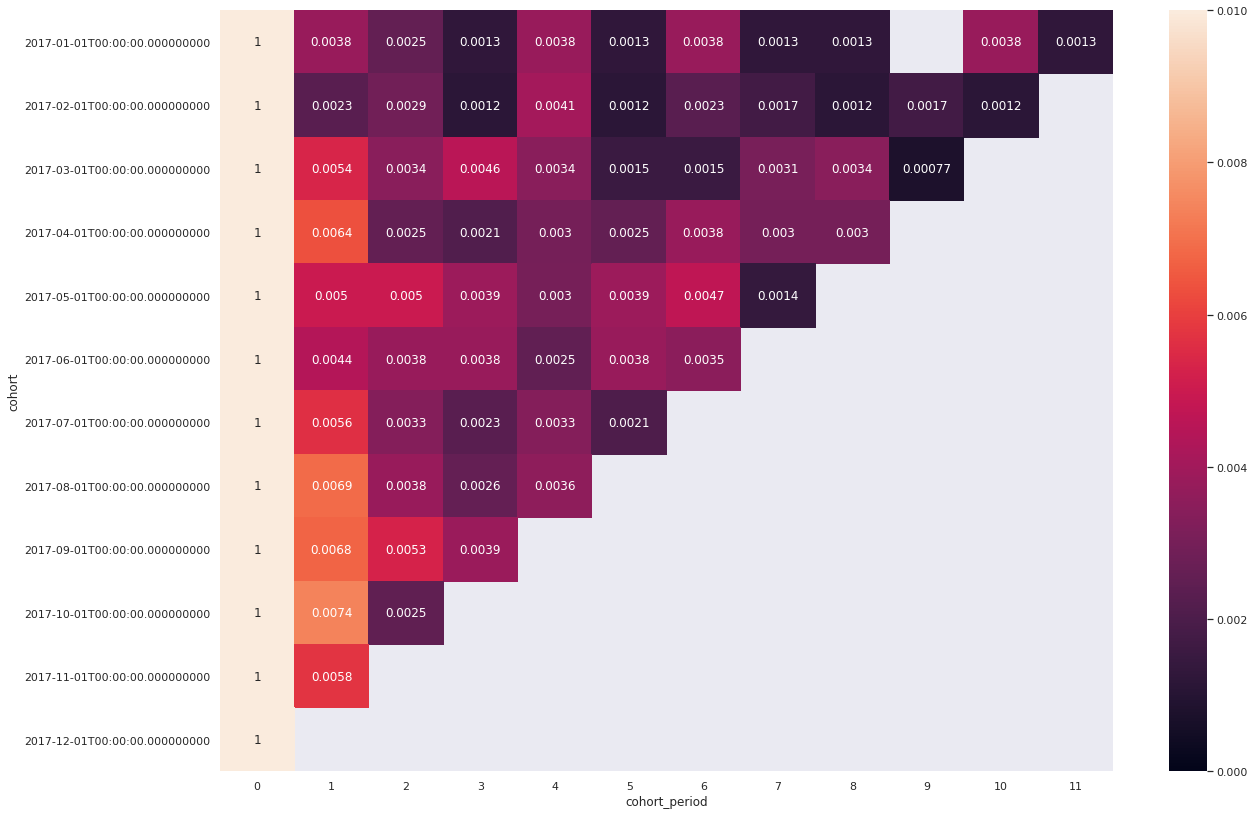

In [102]:

plt.figure(figsize=(20,14))
ax = sns.heatmap(data=cohorts_pivot, annot=True, vmin=0.0,vmax=0.01 )


plt.show()

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

Подготовим датафрейм для проведения анализа. Нам понадобится информация о уникальном идентификаторе пользователя, идентификатор заказа, время заказа и цена. Для этого совершим слияние датасетов и выберем только оплаченные заказы.

In [58]:
rfm_analysis = olist_orders.merge(olist_customers, on='customer_id', how='left').\
merge(olist_order_items, how='left', on='order_id')


In [59]:
rfm_analysis=rfm_analysis.query('order_status in ["approved","invoiced","processing","shipped","delivered"]')

In [60]:
rfm_analysis

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


Выберем только нужные для совершения анализа колонки (они описаны выше).

In [61]:
rfm_analysis=rfm_analysis.loc[:,['order_id','customer_unique_id','order_purchase_timestamp','price']]

In [62]:
rfm_analysis

,order_id,customer_unique_id,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,19.90
...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,174.90
113421,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,205.99
113422,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,179.99
113423,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,179.99


In [63]:
 rfm_analysis['recency'] = (rfm_analysis.order_purchase_timestamp - rfm_analysis.order_purchase_timestamp.max()).dt.days


Найдем максимальную дату в наших данных, относительно которой мы будем считать метрику Recency.

In [64]:
max_date=rfm_analysis.order_purchase_timestamp.max()+ pd.Timedelta(days=1)

In [65]:
max_date

Timestamp('2018-09-04 09:06:57')

Сгруппируем данные по пользователю и найдем необходимые нам метрики:
    Для Recency это разница между последней покупкой пользователя и максимальной датой в датафрейме
    Для Frequency применем к колонке order_id функцию len чтобы узнать длину соответствующего обьекта Series
    (который передаётся в качестве аргумента лямбде-функции) после группировки. 
    Для Monetary применем к колонке price функцию sum чтобы узнать длину соответствующего обьекта Series
    (который передаётся в качестве аргумента лямбде-функции) после группировки. 

In [66]:
df=rfm_analysis.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (max_date - x.max()).days,'order_id': lambda x: len(x), 'price': lambda x: x.sum()}).reset_index()


Переименуем колонки, чтобы их название отражали содержащиеся в них метрики.

In [67]:
df=df.rename(columns={'order_purchase_timestamp':'recency','order_id':'frequency','price':'monetary'})

С помощью функции qcut создадим когорты по метрике Recency (добавляем единицу, т.к. функция qcut начинает счет с 0).
Вычитаем полученное значение из 5, т.к. чем недавнеее совершалась покупка, тем ценнее для нас пользователь и ему должно соответствовать бóльшее значение(4).

In [68]:
df['r']=5 - (pd.qcut(df['recency'],4,labels=False) + 1)

Проверим, равновесны ли полученные когорты (содержат ли они примерно одинаковое число пользователей)

In [69]:
df.groupby('r')['recency'].agg(['mean','count'])

,mean,count
r,,
1,457.475234,23742
2,282.706646,23654
3,171.720678,23822
4,62.472610,23768


Проведем аналогичные действия для получения когорт по метрике Monetary.

In [70]:
df['m']=(pd.qcut(df['monetary'],4,labels=False) + 1)

In [71]:
df.groupby('m')['monetary'].agg(['mean','count'])

,mean,count
m,,
1,29.233362,23881
2,65.638089,23612
3,118.082478,23803
4,356.087592,23690


С когортами по метрике frequency чуть сложнее. Так как подавляющее большинство пользователей совершило одну покупку, равновесных когорт не получится.

In [72]:
df['frequency'].value_counts()

1     83182
2      8950
3      1667
4       629
5       246
6       195
7        46
8        16
9        11
10       11
11       11
12        9
14        3
13        2
15        2
20        2
21        1
16        1
18        1
24        1
Name: frequency, dtype: int64

Поэтому применем функцию lambda к колонке frequency и составим когорты 'на глаз'

In [73]:
df['f'] = df['frequency'].apply(lambda x: x if x in [1,2,3] else 4)

In [74]:
df.groupby('f')['frequency'].agg(['mean','count'])

,mean,count
f,,
1,1.000000,83182
2,2.000000,8950
3,3.000000,1667
4,5.072452,1187


Колонка total_score содержит суммарное значение rfm для каждого пользователя. 

In [75]:
df['total_score'] = (df['r'] + df['f'] + df['m'])

In [76]:
df.sort_values('total_score',ascending=False)

,customer_unique_id,recency,frequency,monetary,r,m,f,total_score
83266,e015ce18751465bc79eeabbe3f0064d5,28,5,1102.63,4,4,4,12
92112,f81d21d920dcc2483b1043a064f3a9bd,75,4,199.60,4,4,4,12
53764,910f0afb84bc778e856d3683c7e8a46a,37,5,1650.00,4,4,4,12
64561,adc19274ee64f1d91ef57bdab658002e,22,6,299.40,4,4,4,12
69822,bbf65e7823171a84e70a495dd6c34ceb,82,4,500.63,4,4,4,12
...,...,...,...,...,...,...,...,...
84442,e33df3ad85a5ef73e5c52ab705c587f7,518,1,19.44,1,1,1,3
7943,151494ff9bd1dfdcb194b4b89a0adf01,446,1,19.50,1,1,1,3
75144,ca45a33e409c8e998391608ba273bfb4,494,1,15.90,1,1,1,3
75130,ca3e5f28d026e91e814eb93179412076,385,1,13.99,1,1,1,3


Также создадим колонку RFM_Score, где суммарное значение будет отражено в виде {r}{f}{m}

In [77]:
df['RFM Score'] = df['r'].map(str) + df['f'].map(str) + df['m'].map(str)

Создадим функцию для создания сегментов на основе колонки total_score. Создадим 7 сегментов в зависимости от значения total_score (суммарное значение rfm метрик)

In [78]:
def segments(df):
    if df['total_score'] >= 9:
        return 'can\'t loose them'
    elif ((df['total_score'] >= 8) and (df['total_score'] < 9)):
        return 'champions'
    elif ((df['total_score'] >= 7) and (df['total_score'] < 8)):
        return 'loyal'
    elif ((df['total_score'] >= 6) and (df['total_score'] < 7)):
        return 'potential'
    elif ((df['total_score'] >= 5) and (df['total_score'] < 6)):
        return 'promising'
    elif ((df['total_score'] >= 4) and (df['total_score'] < 5)):
        return 'hibernating'
    else:
        return 'require activation'

Применем функию

In [79]:
df['segment'] = df.apply(segments,axis=1)

In [80]:
df

,customer_unique_id,recency,frequency,monetary,r,m,f,total_score,RFM Score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,3,1,8,413,champions
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,6,411,potential
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,2,1,4,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,4,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,4,1,7,214,loyal
...,...,...,...,...,...,...,...,...,...,...
94981,fffcf5a5ff07b0908bd4e2dbc735a684,452,2,1570.00,1,4,2,7,124,loyal
94982,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,2,2,1,5,212,promising
94983,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,3,1,5,113,promising
94984,ffff5962728ec6157033ef9805bacc48,124,1,115.00,3,3,1,7,313,loyal


Посмотрим на среднее значение количества потраченных денег (monetary) и количество пользователей для каждого сегмента

In [81]:
df.groupby('segment')['monetary'].agg(['mean','count'])

,mean,count
segment,,
can't loose them,339.118780,9081
champions,221.033686,12328
hibernating,46.443184,11195
loyal,168.516703,17417
potential,132.236361,22031
promising,67.456242,17118
require activation,28.706628,5816


In [82]:
sns.set_theme(rc={'figure.figsize':(13,9)})

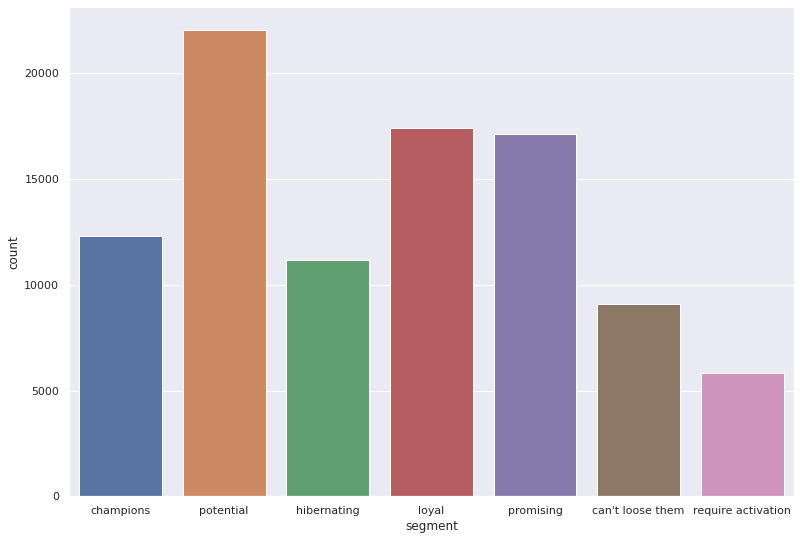

In [83]:
sns.countplot(data=df, x='segment')